Using these data, train models to predict wave height as a function of dominant wave
period, average wave period, the direction from which the waves at the dominant
period are coming, and sea surface temperature

1. Fit a decision tree regressor and random forest regressor with 25 trees.
Compare with a baseline linear model of your choice. Which model performs
best? Report performance on the training, validation, and test dataset.

The forest with 25 trees seems to have performed best overall, except for that the MSE for the single tree for the training data is really low, but that makes sense because it it probably overfit, as the validation and test data have higher errors. 

Tree: training MSE: 3.0778131327740806e-05, test MSE 0.14462761064506796: , validation MSE: 0.13458427104425805

Forest: training MSE: 0.013152178408155218, test MSE: 0.08001013464157104, validation MSE: 0.08184781609565135

Linear model: training MSE: 1.884851777674935, test MSE: 2.1568700734388484, validation MSE: 1.2557350683162922

2. What cost function are you using for each model?

According to google, sklearn typically uses OLS. I couldn't find anything different for the forest vs tree vs linear model, I only saw OLS.

4. What (if any) hyperparameters did you optimize?

I believe only the number of trees was an option, so that was set to 25. 
   
5. If you redo your train/validation splits, do you get the same answers?

Not necessarily, but the MSE values for the forest with 25 trees is a lot more similar to its previous errors from the first split.
   
6. Train a random forest model on this prediction task with a 2, 10, 25, 50, 100,
250, 500, & 1,000 trees. Plot the training and validation error as a function of
number of trees.

The two plots both show that increasing the number of trees SORT OF lowers the MSE, but for the training data it lowers it consistently, while the validation data seems to perform less well. There are some higher and lower values on the plot. 

7. Do you have evidence of overfitting to the training dataset with 1,000 trees?

If i directly look at and compare the MSE values for forest's predictions based on the training vs validation data, the error for the validation data is larger, which probably means the forest is overfit on the training data and doesn't do as good of a job on the validation data 

In [100]:
import sklearn 
import pandas as pd
import numpy as np

from sklearn import tree
import seaborn as sns

In [2]:
# idk what from these ill need but

from sklearn import linear_model
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in data

In [3]:
data = pd.read_csv('buoy.txt', delim_whitespace = True)

# remove 999s and extra variables?

# the ohnly things we care about are: 
    # dominant wave period
    # average wave period
    # the direction from which the waves at the dominant period are coming
    # SST

    # and ultimately we want these to predict wave height



In [4]:
data

,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2023,1,1,0,26,999,99.0,99.0,1.12,12.50,7.69,269,9999.0,999.0,15.3,999.0,99.0,99.0
1,2023,1,1,0,56,999,99.0,99.0,1.16,11.76,7.34,272,9999.0,999.0,15.3,999.0,99.0,99.0
2,2023,1,1,1,26,999,99.0,99.0,1.20,12.50,7.08,268,9999.0,999.0,15.3,999.0,99.0,99.0
3,2023,1,1,1,56,999,99.0,99.0,1.25,10.53,7.33,268,9999.0,999.0,15.4,999.0,99.0,99.0
4,2023,1,1,2,26,999,99.0,99.0,1.27,10.53,7.57,268,9999.0,999.0,15.5,999.0,99.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17280,2023,12,31,21,56,999,99.0,99.0,2.01,14.29,11.19,270,9999.0,999.0,16.7,999.0,99.0,99.0
17281,2023,12,31,22,26,999,99.0,99.0,1.75,15.38,10.37,267,9999.0,999.0,16.7,999.0,99.0,99.0
17282,2023,12,31,22,56,999,99.0,99.0,1.79,13.33,10.50,268,9999.0,999.0,16.8,999.0,99.0,99.0
17283,2023,12,31,23,26,999,99.0,99.0,1.66,14.29,10.32,271,9999.0,999.0,16.8,999.0,99.0,99.0


# Getting rid of unnecessary columns

also renaming them

In [5]:
cols = ['WVHT','DPD','APD','MWD','WTMP']

data = data[cols]

In [6]:
data

,WVHT,DPD,APD,MWD,WTMP
0,1.12,12.50,7.69,269,15.3
1,1.16,11.76,7.34,272,15.3
2,1.20,12.50,7.08,268,15.3
3,1.25,10.53,7.33,268,15.4
4,1.27,10.53,7.57,268,15.5
...,...,...,...,...,...
17280,2.01,14.29,11.19,270,16.7
17281,1.75,15.38,10.37,267,16.7
17282,1.79,13.33,10.50,268,16.8
17283,1.66,14.29,10.32,271,16.8


In [7]:
data.columns = ['Wave Height','Dominant Wave Period','Average Wave Period','Dom Direction','SST']

In [8]:
data

,Wave Height,Dominant Wave Period,Average Wave Period,Dom Direction,SST
0,1.12,12.50,7.69,269,15.3
1,1.16,11.76,7.34,272,15.3
2,1.20,12.50,7.08,268,15.3
3,1.25,10.53,7.33,268,15.4
4,1.27,10.53,7.57,268,15.5
...,...,...,...,...,...
17280,2.01,14.29,11.19,270,16.7
17281,1.75,15.38,10.37,267,16.7
17282,1.79,13.33,10.50,268,16.8
17283,1.66,14.29,10.32,271,16.8


In [9]:
# for decision stree regressor try just changing the max whatever thingy 
# but he lowkey said no dont do that u dont rlly have to chnage it

In [10]:
# now i want to fit both a tree regressor and random forest regressor w 25 trees

In [11]:
# step 1 to this is organize my data into X and y where y will be wave height and X is the array of the other stuff
# i think

# step 2 is train validate test 

# Putting data into arrays 

In [12]:
X1 = data[['Dominant Wave Period','Average Wave Period','Dom Direction', 'SST']].copy()
X = X1.to_numpy()
X

array([[ 12.5 ,   7.69, 269.  ,  15.3 ],
       [ 11.76,   7.34, 272.  ,  15.3 ],
       [ 12.5 ,   7.08, 268.  ,  15.3 ],
       ...,
       [ 13.33,  10.5 , 268.  ,  16.8 ],
       [ 14.29,  10.32, 271.  ,  16.8 ],
       [ 12.5 ,  10.54, 271.  ,  16.9 ]])

In [13]:
y = data['Wave Height']
y = y.to_numpy()
y

array([1.12, 1.16, 1.2 , ..., 1.79, 1.66, 1.7 ])

# Train test split

In [14]:
# training and remaining instead of train and test, remaining will be what i then pull the next stuff from
X_train, X_temp_remaining, y_train, y_temp_remaining = train_test_split(X, y, test_size=0.4)

# now i can split the remaining data into the testing and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_temp_remaining, y_temp_remaining, test_size=0.5)


# X_temp_train is training data, X_test as testing data, X_val is validation data
# y_temp_train is training data, y_test as testing data, y_val is validation data

# Tree regressor

In [15]:
tree1 = DecisionTreeRegressor()

In [16]:
tree1.fit(X_train, y_train)

DecisionTreeRegressor()

In [17]:
# helpful article about scoring with .score() instead of comparing w MSE: https://www.kaggle.com/discussions/getting-started/27261

In [18]:
# basically i dont think i need to do the .predict thing anymore

In [19]:
X1

,Dominant Wave Period,Average Wave Period,Dom Direction,SST
0,12.50,7.69,269,15.3
1,11.76,7.34,272,15.3
2,12.50,7.08,268,15.3
3,10.53,7.33,268,15.4
4,10.53,7.57,268,15.5
...,...,...,...,...
17280,14.29,11.19,270,16.7
17281,15.38,10.37,267,16.7
17282,13.33,10.50,268,16.8
17283,14.29,10.32,271,16.8


# make a dataframe of only the test data so i can do MSE

In [21]:
colz = ['Dominant Wave Period','Average Wave Period','Dom Direction', 'SST']

Test_df = pd.DataFrame(X_test, columns=colz)

Test_df['Wave Height'] = y_test

In [22]:
# ypred is (i think) basically the model's prediction of y values (wave height in this case) for the Xs that we give it w .predict


# In this case the prediction is based off the regressor that we trained on the training data and the prediction of ys from 
# giving it the original X data

# now adding this to my data dataframe


whPred_test1 = tree1.predict(X_test)

In [23]:
Test_df['whPred_test1'] = whPred_test1

In [24]:
Test_df

,Dominant Wave Period,Average Wave Period,Dom Direction,SST,Wave Height,whPred_test1
0,15.38,10.12,268.0,14.7,2.68,3.12
1,4.55,4.64,277.0,18.7,0.73,0.99
2,12.50,5.52,260.0,17.5,0.81,0.78
3,6.25,5.86,271.0,14.5,0.89,1.66
4,11.76,9.32,275.0,14.0,0.80,1.22
...,...,...,...,...,...,...
3452,7.69,5.02,267.0,13.0,1.10,1.06
3453,7.14,5.02,273.0,19.7,0.93,0.77
3454,11.76,8.66,251.0,14.0,0.69,0.57
3455,11.11,6.58,264.0,18.4,0.94,0.88


In [25]:
# MSE for test data for tree1

mean_squared_error(Test_df['Wave Height'],Test_df['whPred_test1'])

0.14462761064506796

# df of only val data, MSE

In [26]:
Val_df = pd.DataFrame(X_val, columns=colz)

Val_df['Wave Height'] = y_val


In [27]:
whPred_val1 = tree1.predict(X_val)

Val_df['whPred_val1'] = whPred_val1

In [28]:
Val_df

,Dominant Wave Period,Average Wave Period,Dom Direction,SST,Wave Height,whPred_val1
0,11.76,11.00,268.0,14.7,2.48,2.67
1,5.88,4.72,270.0,20.7,0.67,0.85
2,4.55,4.02,268.0,14.4,1.11,1.03
3,14.29,6.30,178.0,18.8,0.46,0.71
4,5.00,4.76,274.0,18.8,0.76,0.99
...,...,...,...,...,...,...
3452,10.53,8.34,205.0,18.0,0.99,0.76
3453,13.33,8.56,159.0,19.3,0.76,0.68
3454,11.76,5.18,254.0,17.4,0.80,0.61
3455,13.33,4.80,208.0,21.7,0.68,0.69


In [29]:
# MSE for validation data for tree1

mean_squared_error(Val_df['Wave Height'],Val_df['whPred_val1'])

0.13458427104425805

# df of only training data, MSE

In [30]:
Train_df = pd.DataFrame(X_train, columns=colz)

Train_df['Wave Height'] = y_train


In [31]:
whPred_train1 = tree1.predict(X_train)

Train_df['whPred_train1'] = whPred_train1

In [33]:
# MSE for training data for tree1

mean_squared_error(Train_df['Wave Height'],Train_df['whPred_train1'])

# very very small

3.0778131327740806e-05

# Baseline linear model

just linear regression

In [35]:
from sklearn import linear_model

In [36]:
reg = linear_model.LinearRegression()

In [37]:
reg.fit(X_train,y_train)

LinearRegression()

In [53]:
# test MSE

In [38]:
whPred_test2 = reg.predict(X_test)

In [39]:
Test_df['whPred_test2'] = whPred_test2

In [41]:
mean_squared_error(Test_df['Wave Height'],Test_df['whPred_test2'])

2.1568700734388484

In [44]:
# val MSE

In [45]:
whPred_val2 = reg.predict(X_val)

In [46]:
Val_df['whPred_val2'] = whPred_val2

In [47]:
mean_squared_error(Val_df['Wave Height'],Val_df['whPred_val2'])

1.2557350683162922

In [48]:
# train MSE

In [49]:
whPred_train2 = reg.predict(X_train)

In [51]:
Train_df['whPred_train2'] = whPred_train2

In [52]:
mean_squared_error(Train_df['Wave Height'],Train_df['whPred_train2'])

1.884851777674935

# Forest regressor

In [56]:
forest1 = RandomForestRegressor(n_estimators=25)

In [57]:
forest1.fit(X_train, y_train)

RandomForestRegressor(n_estimators=25)

In [58]:
# test MSE

In [59]:
whPred_test3 = forest1.predict(X_test)

In [60]:
Test_df['whPred_test3'] = whPred_test3

In [61]:
mean_squared_error(Test_df['Wave Height'],Test_df['whPred_test3'])

0.08001013464157104

In [62]:
# validation MSE

In [63]:
whPred_val3 = forest1.predict(X_val)
Val_df['whPred_val3'] = whPred_val3

In [64]:
mean_squared_error(Val_df['Wave Height'],Val_df['whPred_val3'])

0.08184781609565135

In [65]:
# train MSE

In [66]:
whPred_train3 = forest1.predict(X_train)
Train_df['whPred_train3'] = whPred_train3

In [67]:
mean_squared_error(Train_df['Wave Height'],Train_df['whPred_train3'])

0.013152178408155218

# Redoing train test split 

In [72]:
# training and remaining instead of train and test, remaining will be what i then pull the next stuff from
X_train, X_temp_remaining, y_train, y_temp_remaining = train_test_split(X, y, test_size=0.25)

# now i can split the remaining data into the testing and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_temp_remaining, y_temp_remaining, test_size=0.4)


# X_temp_train is training data, X_test as testing data, X_val is validation data
# y_temp_train is training data, y_test as testing data, y_val is validation data

In [73]:
tree2 = DecisionTreeRegressor()

In [74]:
tree2.fit(X_train, y_train)

DecisionTreeRegressor()

In [81]:
Test_df2 = pd.DataFrame(X_test, columns=colz)
Test_df2['Wave Height'] = y_test

Val_df2 = pd.DataFrame(X_val, columns=colz)
Val_df2['Wave Height'] = y_val

Train_df2 = pd.DataFrame(X_train, columns=colz)
Train_df2['Wave Height'] = y_train

In [82]:
# test MSE
whPred_test4 = tree2.predict(X_test)
Test_df2['whPred_test4'] = whPred_test4
mean_squared_error(Test_df2['Wave Height'],Test_df2['whPred_test4'])

0.15141478017740068

In [83]:
# val MSE
whPred_val4 = tree2.predict(X_val)
Val_df2['whPred_val4'] = whPred_val4
mean_squared_error(Val_df2['Wave Height'],Val_df2['whPred_val4'])

0.15206415558126085

In [84]:
# train MSE
whPred_train4 = tree2.predict(X_train)
Train_df2['whPred_train4'] = whPred_train4
mean_squared_error(Train_df2['Wave Height'],Train_df2['whPred_train4'])

3.3568618375376066e-05

In [75]:
forest2 = RandomForestRegressor(n_estimators=25)

In [76]:
forest2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=25)

In [85]:
# test MSE
whPred_test4 = forest2.predict(X_test)
Test_df2['whPred_test4'] = whPred_test4
mean_squared_error(Test_df2['Wave Height'],Test_df2['whPred_test4'])

0.08213677049250546

In [86]:
# val MSE
whPred_val4 = forest2.predict(X_val)
Val_df2['whPred_val4'] = whPred_val4
mean_squared_error(Val_df2['Wave Height'],Val_df2['whPred_val4'])

0.08247756388358075

In [87]:
# train MSE
whPred_train4 = forest2.predict(X_train)
Train_df2['whPred_train4'] = whPred_train4
mean_squared_error(Train_df2['Wave Height'],Train_df2['whPred_train4'])

0.012580330004624503

# Different numbers of trees 

In [ ]:
# 2, 10, 25, 50, 100, 250, 500, & 1,000 trees

In [93]:
forest4 = RandomForestRegressor(n_estimators=2)

In [94]:
forest5 = RandomForestRegressor(n_estimators=10)
forest6 = RandomForestRegressor(n_estimators=25)
forest7 = RandomForestRegressor(n_estimators=50)
forest8 = RandomForestRegressor(n_estimators=100)
forest9 = RandomForestRegressor(n_estimators=250)
forest10 = RandomForestRegressor(n_estimators=500)
forest11 = RandomForestRegressor(n_estimators=1000)

In [95]:
forest4.fit(X_train, y_train)
forest5.fit(X_train, y_train)
forest6.fit(X_train, y_train)
forest7.fit(X_train, y_train)
forest8.fit(X_train, y_train)
forest9.fit(X_train, y_train)
forest10.fit(X_train, y_train)
forest11.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [97]:
# training data

mse_results = []
num_trees = [2, 10, 25, 50, 100, 250, 500, 1000]  

forests = [forest4, forest5, forest6, forest7, forest8, forest9, forest10, forest11]

#iterate
for i, forest in enumerate(forests):
    whPred_train = forest.predict(X_train)
    mse = mean_squared_error(y_train, whPred_train)
    # Store results
    mse_results.append({'Number of Trees': num_trees[i], 'MSE': mse})

# df from results
mse_df = pd.DataFrame(mse_results)


In [98]:
mse_df

,Number of Trees,MSE
0,2,0.032863
1,10,0.015449
2,25,0.012501
3,50,0.011379
4,100,0.010914
5,250,0.010656
6,500,0.010564
7,1000,0.010577


<Axes: xlabel='Number of Trees', ylabel='MSE'>

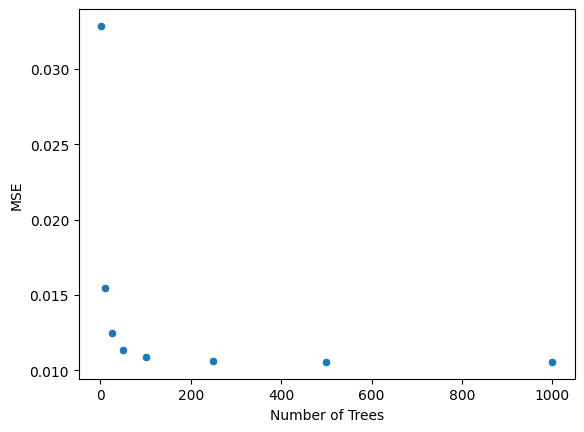

In [101]:
# scatterplot  
sns.scatterplot(data=mse_df, x="Number of Trees", y="MSE")


In [102]:
# validation data

mse_results = []
num_trees = [2, 10, 25, 50, 100, 250, 500, 1000]  

forests = [forest4, forest5, forest6, forest7, forest8, forest9, forest10, forest11]

#iterate
for i, forest in enumerate(forests):
    whPred_val = forest.predict(X_val)
    mse = mean_squared_error(y_val, whPred_val)
    # Store results
    mse_results.append({'Number of Trees': num_trees[i], 'MSE': mse})

# df from results
mse_df2 = pd.DataFrame(mse_results)


In [104]:
mse_df2

,Number of Trees,MSE
0,2,0.108003
1,10,0.086647
2,25,0.078293
3,50,0.079434
4,100,0.076655
5,250,0.076853
6,500,0.076631
7,1000,0.076365


<Axes: xlabel='Number of Trees', ylabel='MSE'>

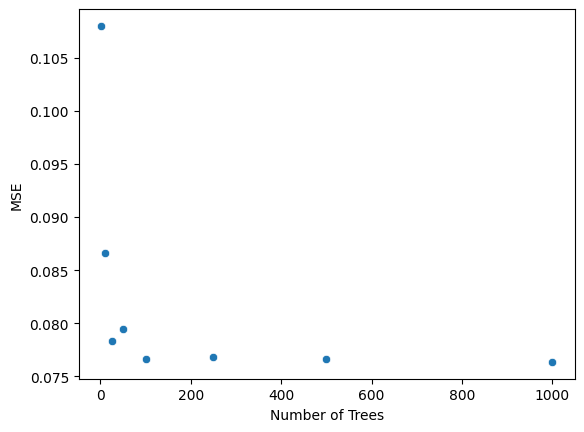

In [103]:
# scatterplot  
sns.scatterplot(data=mse_df2, x="Number of Trees", y="MSE")

In [108]:
# training
mse_df

,Number of Trees,MSE
0,2,0.032863
1,10,0.015449
2,25,0.012501
3,50,0.011379
4,100,0.010914
5,250,0.010656
6,500,0.010564
7,1000,0.010577


In [107]:
# val
mse_df2

,Number of Trees,MSE
0,2,0.108003
1,10,0.086647
2,25,0.078293
3,50,0.079434
4,100,0.076655
5,250,0.076853
6,500,0.076631
7,1000,0.076365


In [110]:
# if validation error way bigger than train error is overfitting, and most are in fact larger